In [15]:
from typing import Annotated

from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool



class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")


@tool
def hello_world():
    """Trigger this function when user asks you to.
    Returns hello string.
    """
    return "Hello, webinar!"


def chatbot(state: State):
    llm_with_tools = llm.bind_tools(tools=[hello_world])
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("trigger_hello_world_function", ToolNode(tools=[hello_world]))


graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"__end__": "__end__", "tools": "trigger_hello_world_function"},
)
graph_builder.add_edge("trigger_hello_world_function", END)

graph = graph_builder.compile()

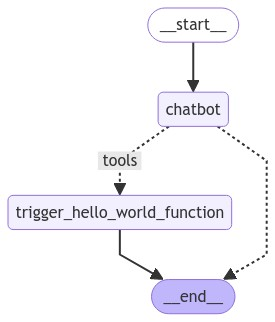

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [17]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)


Assistant: [{'text': 'Certainly! I\'d be happy to trigger the "hello_world" function for you. This function doesn\'t require any parameters, so we can call it directly. Here\'s how we\'ll do that:', 'type': 'text'}, {'id': 'toolu_01L5Pqsn8bva7qX6QNNEDD9g', 'input': {}, 'name': 'hello_world', 'type': 'tool_use'}]
Assistant: Hello, webinar!
Goodbye!
